In [42]:
# big test of least squares
# 1. import the b0 map
# import b0map as an object
import numpy as np  
import b0
b0map = b0.b0()
filename_to_import_csv_data_from = r'./\data\240619\Thursday_ball_R120_12pts_bvals_shifted.csv'
b0map.import_from_csv(filename_to_import_csv_data_from)
b0map.transfer_coordinates_of_the_path_from_cosi_to_magnet()


# change coordinates to magnet



No path object given on construction of b0 object.
 b0 instance initialized without path.
importing b0 object from csv file./\data\240619\Thursday_ball_R120_12pts_bvals_shifted.csv
No path object given on construction of b0 object.
 b0 instance initialized without path.
warning. path file  /home/cosi/cosi-measure/Software/COSI2/data/240719/Thursday_ball_R120_12pts,,,,,,
 not used. path data taken from csv!
importing path from a csv file
ROTATING THE PATH NOW!
path center set to:  [-1.49212153e-03  2.23818229e-03 -3.57200575e+00]
ROTATING THE MAGNET NOW!
warning! euler angles of the magnet changed!
len(path.r)= 11487
len(b0Data)= 11487
-111.4292539392357  < x <  111.4307460607643
-116.42575607208154  < y <  115.00424392791848
-115.00349786715418  < z <  107.85650213284583
path step size:  8.569999999999936 8.569999999999936 8.569999999999936
xPts:  [-111.42925394 -102.85925394  -94.28925394  -85.71925394  -77.14925394
  -68.57925394  -60.00925394  -51.43925394  -42.86925394  -34.2992539

In [43]:
print(np.nanmin(b0map.b0Data[:,:,:,0]))
print(np.nanmax(b0map.b0Data[:,:,:,0]))

# spherical decomposition
diameter_of_sphere = b0map.path.radius*2
order = 17
resolution_of_sph_decomp = 10
print(diameter_of_sphere)
b0map.fitSphericalHarmonics(maxorder=order,dsv=diameter_of_sphere,resol=resolution_of_sph_decomp)

resolution_of_sph_fit=20
print('interpolating field with sph order %d, resol %.0f mm'%(order,resolution_of_sph_fit))

b0map.interpolateField(resol=resolution_of_sph_fit,dsv=diameter_of_sphere)


-47.809
-47.394
239.91103289828555
(27, 28, 27)
Mean field strength in 23 cm sphere: -47.55 mT
Inhomogeneity in 23 cm sphere: -5783 ppm
Inhomogeneity of fit: 5679 ppm
Error: -332 ppm
saved numpy array as ./data/tmp/SpHData.npy
interpolating field with sph order 17, resol 20 mm
sph coefficients loaded
making a fine coordinate grid
Inhomogeneity of fit: 4142 ppm
saved numpy array as ./data/tmp/B0_interpolated.npy


In [45]:
print('now we have an interpolated field.')
print(np.shape(b0map.interpolatedField))
print('on a coordinate grid')
print(np.shape(b0map.coord_grid_fine))



now we have an interpolated field.
(12, 12, 12)
on a coordinate grid
(3, 12, 12, 12)


In [46]:
# shim magnets positinoing

mu                  = 1e-7

magSizeOuter        = 6*1e-3        #size of shim magnets
bRem                = 1.35 # [T]      #remanence field of shim magnets

#shim tray configuration
def ringposFromTrayNr(trays_ocp):
    trayslitspacing = 9e-3 # [m]
    coordinates = []
    for tray_pos in trays_ocp:
        coordinate = trayslitspacing*tray_pos-4.5e-3 if tray_pos>0 else trayslitspacing*tray_pos+4.5e-3
        coordinates.append(coordinate)
    return coordinates


shimRadius          = 276*1e-3#276*1e-3 <- was set by Tom!      # radius on which the shim magnets are placed

trays_occupied = [-7,-5,1,14] #[-18,-5,1,12] <- 27mm best  [-7,-5,1,14] 997
ringPositions       = ringposFromTrayNr(trays_occupied)#[-121.5*1e-3, -40.5*1e-3, 31.5*1e-3, 121.5*1e-3]#np.linspace(-ringspacingouter,ringspacingouter,4)#np.linspace(-0.1755,0.1755,4)          #np.linspace(-0.2295, .2295, 4) #Z positions to place shin rubgs
print(np.array(ringPositions)*1e3)


[-58.5 -40.5   4.5 121.5]


In [47]:

magsPerSegment      = 7             # number of magnets peer shim tray segment
anglePerSegment     = 19.25 #the angular distance in degrees between the furthest magnets in a shim tray (span of magnets in shim tray)
numSegments         = 12 #corresponds to the number of shim trays


segmentAngles       = np.linspace(0,360, numSegments, endpoint = False)

magAngles           = np.linspace(-anglePerSegment/2, anglePerSegment/2, magsPerSegment) 

print('let us position some magnets on a circumference of a R=%.0f mm YZ circle with X=0'%(shimRadius*1000))

positions = []
for ringPosition in ringPositions:
    for segmentAngle in segmentAngles:
        for magAngle in magAngles:
            # the most important line is this. Our bore is along X, so we create an array of positions along X, not along Z!
            #positions.append((shimRadius*np.cos((segmentAngle+magAngle)*np.pi/180), shimRadius*np.sin((segmentAngle+magAngle)*np.pi/180), ringPosition))
            positions.append((ringPosition,shimRadius*np.cos((segmentAngle+magAngle)*np.pi/180), shimRadius*np.sin((segmentAngle+magAngle)*np.pi/180)))

        # check if rings are in the right plane
        #print(positions) 

print(len(positions))


let us position some magnets on a circumference of a R=276 mm YZ circle with X=0
336


magnet created, dipole points to  [0. 1. 0.]
HALLO?!
(-0.0585, 0.27211479674710887, -0.04614691096140277)
x vector length in single magnet simulation:  12
calculating field of one shim magnet at  -0.0585 0.27211479674710887 -0.04614691096140277
magnet created, dipole points to  [0. 1. 0.]
HALLO?!
(-0.0585, 0.2742709847847707, -0.030845208788272026)
x vector length in single magnet simulation:  12
calculating field of one shim magnet at  -0.0585 0.2742709847847707 -0.030845208788272026
magnet created, dipole points to  [0. 1. 0.]
HALLO?!
(-0.0585, 0.27556740718070843, -0.015446815196073495)
x vector length in single magnet simulation:  12
calculating field of one shim magnet at  -0.0585 0.27556740718070843 -0.015446815196073495
magnet created, dipole points to  [0. 1. 0.]
HALLO?!
(-0.0585, 0.276, 0.0)
x vector length in single magnet simulation:  12
calculating field of one shim magnet at  -0.0585 0.276 0.0
magnet created, dipole points to  [0. 1. 0.]
HALLO?!
(-0.0585, 0.275567407180708

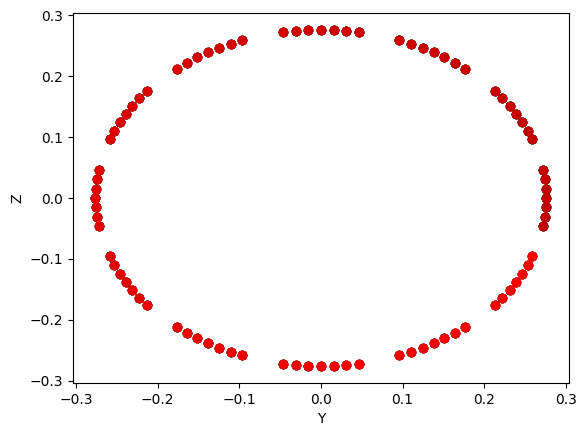

In [49]:

import matplotlib.pyplot as plt
for idx,position in enumerate(positions):

    plt.scatter(position[1],position[2],color = [idx/len(positions),0,0])

plt.xlabel('Y')
plt.ylabel('Z')


initialField = b0map.interpolatedField
numMags = len(positions)
coordinate_grid = b0map.coord_grid_fine



magnetFields = np.zeros((np.shape(initialField)+(3,numMags)), dtype = np.float32)
magnetFields_fair = np.zeros((np.shape(initialField)+(3,numMags)), dtype = np.float32)


def magnetization(bRem, dimensions, shape = 'cube', evalDistance = 1):
    #Use the analytical expression for the z component of a cube magnet to estimate
    #dipole momentstrength for correct scaling. Dipole approximation only valid 
    #far-ish away from magnet, comparison made at 1 meter distance.
    if shape == 'cube':
        b_analytic = (bRem/np.pi) *(np.arctan2(dimensions**2, 2*evalDistance *np.sqrt(4*(evalDistance**2) + 2*(dimensions**2)))-\
                        np.arctan2(dimensions**2, 2*(dimensions + evalDistance)*\
                                   np.sqrt(4*((dimensions+evalDistance)**2)+2*(dimensions**2))))
    
        dip_mom = b_analytic * (dimensions/2 + evalDistance)**3 /(2*mu) #strength of the dipole moment
    
    return dip_mom

from utils import shimming_magnet

shimming_magnets = []

DSV = b0map.path.radius*2

dip_mom = magnetization(bRem=bRem,dimensions=magSizeOuter)
dip_vec = mu*np.array([0,dip_mom,0]) #initially along y

for idx1, position in enumerate(positions):
    magnet = shimming_magnet.shimming_magnet(position=position,rotation_yz=0)
    #magnetFields[:,:,:,:,idx1] = magnet.singleMagnet(position, grid=coordinate_grid)
    magnetFields[:,:,:,:,idx1] = magnet.OLD_singleMagnet(position=position,dipoleMoment = dip_vec, 
                                                         simDimensions=[DSV*1e-3,DSV*1e-3,DSV*1e-3],
                                                         resolution=1/resolution_of_sph_fit*1e3,
                                                         plotFields=False)[:,:,:,:] #singleMagnet(position, grid=coordinate_grid)

    #magnetFields_fair[:,:,:,:,idx1] = magnet.singleMagnet(position=position,grid=coordinate_grid,plotFields=False)

    shimming_magnets.append(magnet)

magnetFields *= 1e3

print(DSV)


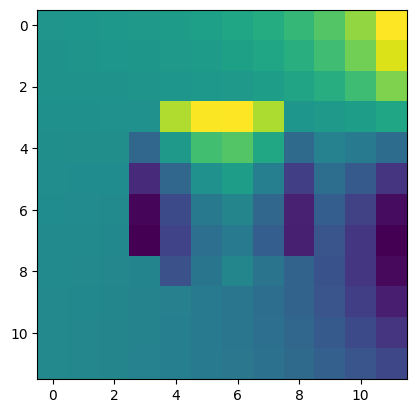

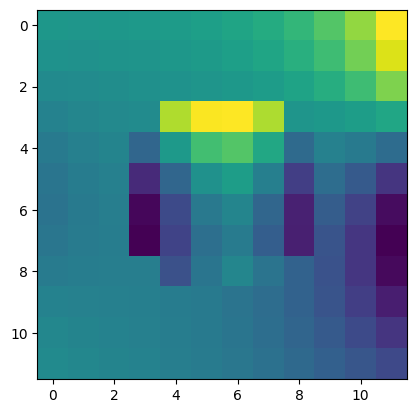

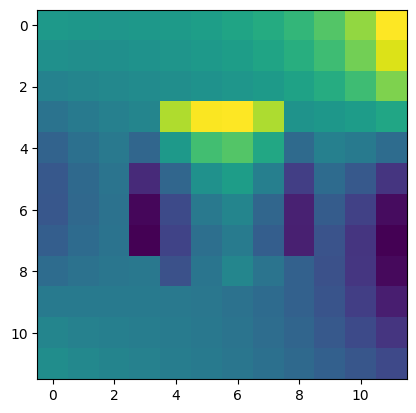

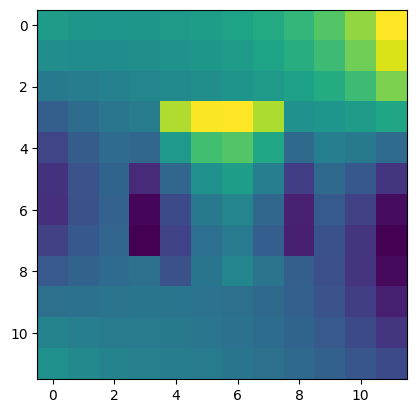

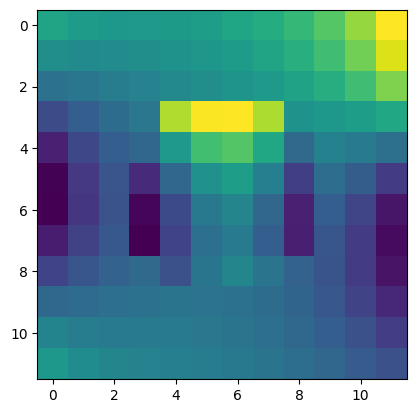

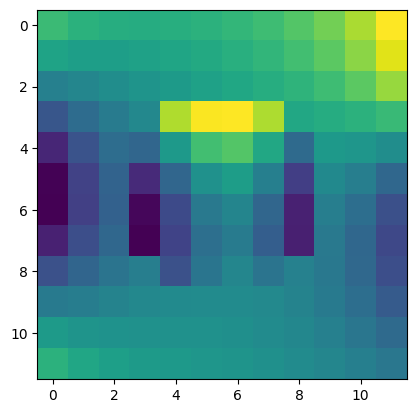

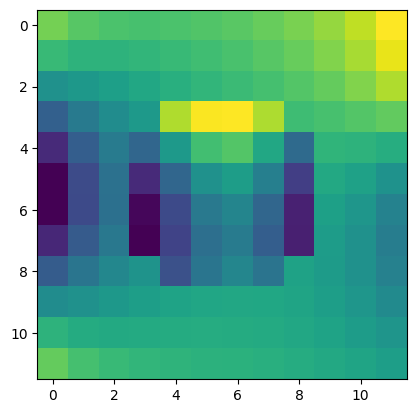

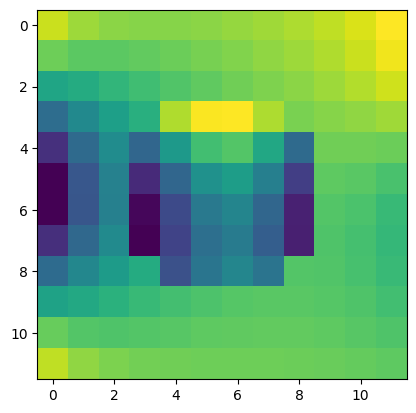

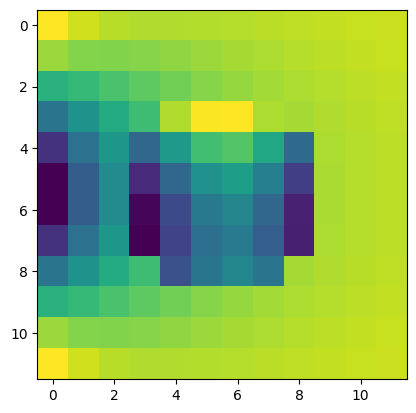

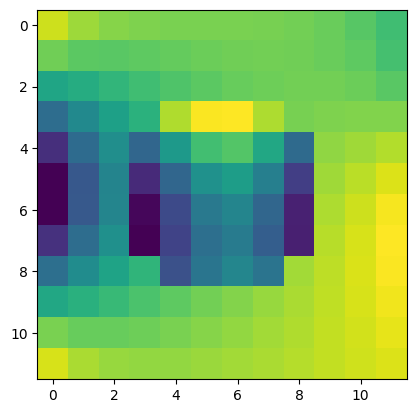

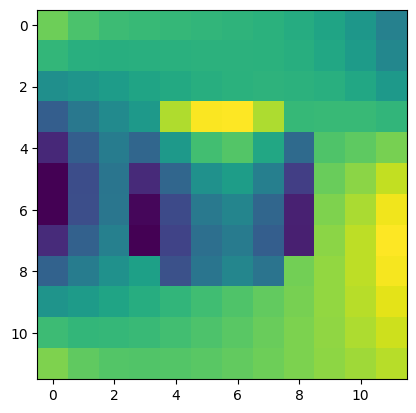

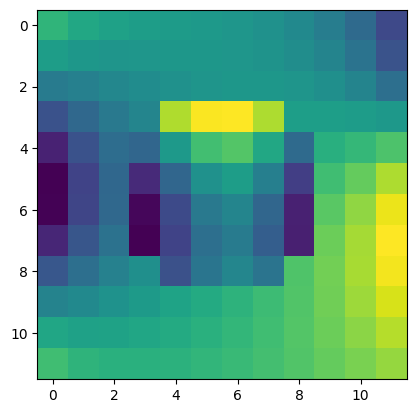

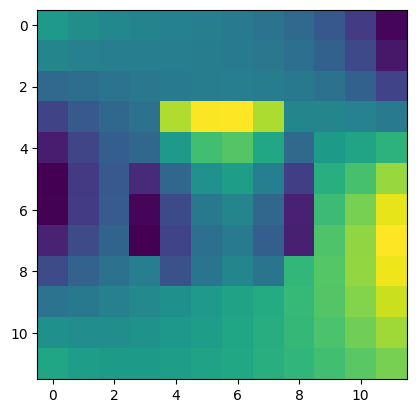

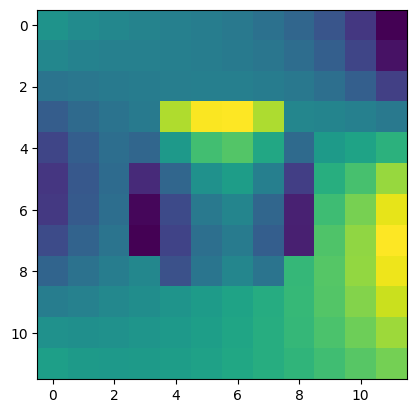

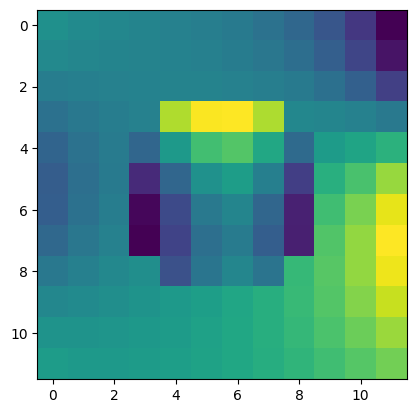

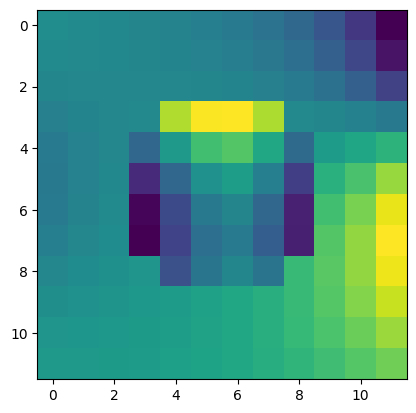

In [51]:
plt.cla()
for i in range(16):
    alpha = i*np.pi/16
    plt.imshow(magnetFields[1,:,:,2,0]*np.cos(alpha)+magnetFields[1,:,:,1,45]*np.sin(alpha))
    plt.imshow(b0map.interpolatedField[1,:,:])
    plt.show()

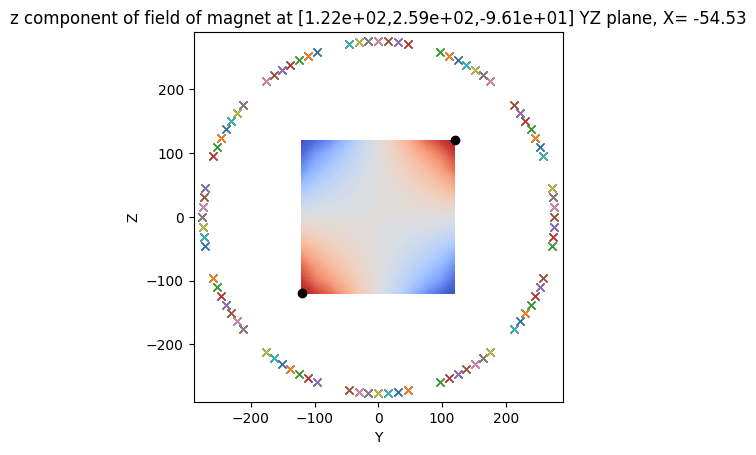

In [52]:
# visualize the field of one magnet
resolution = 1/resolution_of_sph_fit*1e3

X = b0map.xDim_SPH_fine*1e0
Y = b0map.yDim_SPH_fine*1e0
Z = b0map.zDim_SPH_fine*1e0

ONEMAGNETFIELD = magnetFields[:,:,:,:,0]*0

ax = plt.figure().add_subplot()
for idx in range(0,336,1):

    position = positions[idx]

    x,y,z = coordinate_grid
    y2d, z2d = np.meshgrid(Y,Z,indexing='xy')

    ONEMAGNETFIELD += magnetFields[:,:,:,:,idx]#+magnetFields[:,:,:,:,idx+14]

    
    
    
    ax.plot(position[1]*1000,position[2]*1000,'x')
scale = 5e-0
yzsliceindex = 3
ax.contourf(y2d,z2d,ONEMAGNETFIELD[yzsliceindex,:,:,2],cmap='coolwarm',levels=64)#,vmin = -scale, vmax= scale)

ax.plot(min(Y),min(Z),'ko')
ax.plot(max(Y),max(Z),'ko')

ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_xlim(-290,290)
ax.set_ylim(-290,290)
ax.set_aspect(1)
                
ax.set_title('z component of field of magnet at [%.2e,%.2e,%.2e] YZ plane, X= %.2f'%(position[0]*1e3,position[1]*1e3,position[2]*1e3,X[yzsliceindex]))

plt.show()

(12, 12, 12, 3, 336)


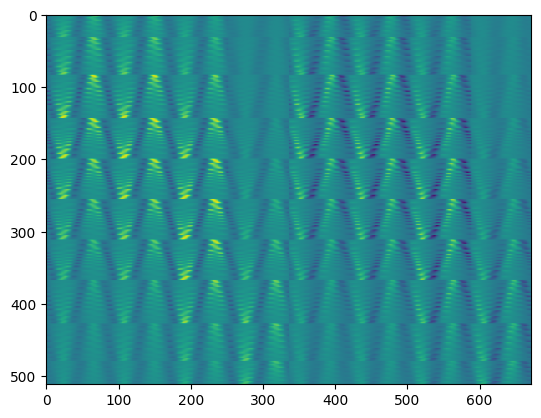

In [53]:
# mask the magnet fields
# DSV = b0map.path.radius*2 # DEFINED ABOVE!
DSV_INNER = b0map.path.radius*1.25#1.95 # DEFINED ABOVE!
# make a spherical mask with diameter DSV
sphereMask = np.zeros(np.shape(coordinate_grid[0]), dtype = float)
sphereMask[np.square(coordinate_grid[0]) + np.square(coordinate_grid[1]) + np.square(coordinate_grid[2]) <= (DSV/2)**2] = 1 
sphereMask[np.square(coordinate_grid[0]) + np.square(coordinate_grid[1]) + np.square(coordinate_grid[2]) <= (DSV_INNER/2)**2] = 0 

sphereMask[sphereMask == 0] = np.nan

print(np.shape(magnetFields))

maskedFields = magnetFields[sphereMask == 1, :,:].astype(float)
maskedFields_stacked = np.hstack((maskedFields[:,1,:],maskedFields[:,2,:])) # WE HAVE Y AND Z


plt.imshow(maskedFields_stacked) #



In [54]:
# masking the magnet fields

print(np.shape(maskedFields_stacked))

vector_of_magnet_rotations = np.zeros(len(shimming_magnets))

stackedRotationVector = np.hstack([np.sin(vector_of_magnet_rotations),np.cos(vector_of_magnet_rotations)])
print(np.shape(stackedRotationVector))

rotatedFieldOfShimMagnetsStacked = np.matmul(maskedFields_stacked,stackedRotationVector)

print(np.shape(rotatedFieldOfShimMagnetsStacked))


(512, 672)
(672,)
(512,)


In [55]:
#plt.imshow(initialField[1,:,:])

initialFieldMasked = initialField[sphereMask == 1]
print(np.shape(initialFieldMasked))
print(np.shape(initialField))

(512,)
(12, 12, 12)


In [56]:
# ok now we have magnet fields and vector of magnet rotations. we can make fields now
def _dataFitting(shimVector):
            #factor = 1+np.random.randint(10)/1000
            #shimVector = shimVector*factor
            stackedRotationVector = np.hstack([np.sin(shimVector),np.cos(shimVector)])
            shimField = np.matmul(maskedFields_stacked*1.00,stackedRotationVector)+initialFieldMasked
            #optimizedField = np.matmul(magnetFields[...,1,:], np.cos(shimVector)) + np.matmul(magnetFields[...,2,:], np.sin(shimVector))
            #shimField = optimizedField + initialField
            #shimField[np.isnan(shimField)] = np.nanmean(shimField)*1
            #shimField = shimField[~np.isnan(shimField)]
            

            #shimField = shimField.flatten()

            return np.square(((shimField)/np.mean(shimField)) -1)*1e9


[0.00000000e+00 2.32047907e-08 0.00000000e+00]
[ 0.00000000e+00 -8.24973966e-09 -2.16888014e-08]
[ 0.00000000e+00 -5.51744022e-09 -2.25393027e-08]
[ 0.00000000e+00 -4.80429126e-09 -2.27020064e-08]
[ 0.00000000e+00 -5.42445249e-09 -2.25618622e-08]
[ 0.00000000e+00 -6.80432063e-09 -2.21847590e-08]
[ 0.00000000e+00 -8.40189223e-09 -2.16303148e-08]
[0.00000000e+00 2.32047907e-08 5.16586004e-13]
[0.00000000e+00 2.32047907e-08 2.29593581e-15]
[ 0.00000000e+00 -7.29234745e-09 -2.20291620e-08]
[ 0.00000000e+00 -4.87367458e-09 -2.26872124e-08]
[0.00000000e+00 2.32047906e-08 1.58524806e-12]
[ 0.00000000e+00 -3.22727045e-09 -2.29792741e-08]
[0.00000000e+00 2.47093797e-09 2.30728580e-08]
[ 0.00000000e+00 -2.93631968e-09  2.30182610e-08]
[ 0.00000000e+00 -1.31142384e-08  1.91436429e-08]
[ 0.0000000e+00 -1.5434104e-08  1.7327745e-08]
[ 0.00000000e+00 -1.74491011e-08  1.52967703e-08]
[ 0.00000000e+00 -1.91451273e-08  1.31120712e-08]
[ 0.00000000e+00 -2.05318182e-08  1.08123426e-08]
[ 0.00000000e+00 -

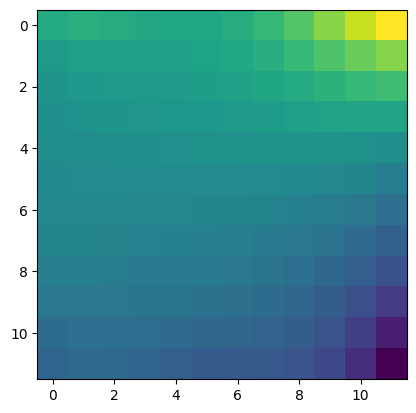

In [57]:
#render the field of rotated magnets
#optimized_vector_of_magnet_rotations = np.zeros(len(shimming_magnets))#+np.pi/4*8.05#np.random.randint(40)*2*np.pi/40
optimized_vector_of_magnet_rotations = np.load('opt1e3.npy')
shimming_magnets[0].render_field(coordinate_grid)
shimFieldRendered = shimming_magnets[0].B0*0

for idx, magnet in enumerate(shimming_magnets):
    alpha = optimized_vector_of_magnet_rotations[idx]
    magnet.rotation_yz = alpha
    magnet.render_field(grid=coordinate_grid)
    shimFieldRendered += magnet.B0

plt.imshow(shimFieldRendered[2,:,:,2])


In [58]:
# now do the least squares optimization
vector_of_magnet_rotations =np.load('opt1e3.npy')#
#vector_of_magnet_rotations = np.zeros(len(shimming_magnets))#vector_of_magnet_rotations*0 ##
cost = _dataFitting(vector_of_magnet_rotations)

print(np.sum(cost))

# least squares optimization of the rotation vector
from scipy.optimize import least_squares

initialGuess = vector_of_magnet_rotations
#initialGuess[initialGuess<0.001] = 0.001
lsqData = least_squares(_dataFitting, initialGuess, max_nfev=6400, xtol = 1e-6,ftol=0, verbose=2,bounds=(initialGuess*0,initialGuess*0+2*np.pi))


7022.641761491303
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6771e+05                                    4.31e+05    


C:\Users\kuliko02\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_lsq\least_squares.py:824: UserWarning: Setting `ftol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  ftol, xtol, gtol = check_tolerance(ftol, xtol, gtol, method)


       1              2         7.9127e+04      8.86e+04       3.96e-01       2.60e+05    
       2              3         5.2325e+04      2.68e+04       3.22e-01       1.47e+05    
       3              4         4.0571e+04      1.18e+04       2.09e-01       1.13e+05    
       4              5         3.4710e+04      5.86e+03       1.87e-01       7.73e+04    
       5              6         3.1597e+04      3.11e+03       1.33e-01       5.90e+04    
       6              7         2.9671e+04      1.93e+03       1.28e-01       5.50e+04    
       7              8         2.8254e+04      1.42e+03       9.90e-02       3.97e+04    
       8              9         2.7282e+04      9.72e+02       9.85e-02       4.73e+04    
       9             10         2.6433e+04      8.48e+02       8.14e-02       3.25e+04    
      10             11         2.5811e+04      6.22e+02       8.10e-02       4.04e+04    
      11             12         2.5234e+04      5.77e+02       6.96e-02       2.82e+04    

In [ ]:
optimized_vector_of_magnet_rotations = lsqData.x
np.save('opt1e3',optimized_vector_of_magnet_rotations)
#np.save('opt336magnets_27mm_1607ppm',optimized_vector_of_magnet_rotations)

#print(optimized_vector_of_magnet_rotations)

shimFieldRendered = shimming_magnets[0].B0[:,:,:,1]*0

for idx, magnet in enumerate(shimming_magnets):
    alpha = optimized_vector_of_magnet_rotations[idx]
    magnet.rotation_yz = alpha#+0*np.pi/4
    magnet.position = np.asarray(positions[idx])*1
    #magnet.update_rotation(rotation_yz=alpha+0*np.pi/2)
    magnet.render_field(grid=coordinate_grid)
    shimFieldRendered += magnet.B0[:,:,:,2]#magnet.B0[:,:,:,1]*np.cos(alpha)+magnet.B0[:,:,:,2]*np.sin(alpha)

shimField_fair = initialField*1+shimFieldRendered*1e3#[:,:,:]*1+np.multiply(shimFieldRendered[:,:,:,2]*1000,lsqData.x)#+shimFieldRendered[:,:,:,1]*1000 #???? why 1st not 2nd component!?!!s


optimizedField = np.matmul(magnetFields[...,1,:], np.sin(lsqData.x)) + np.matmul(magnetFields[...,2,:], np.cos(lsqData.x))
#print(np.shape(optimizedField))



shimField = initialField+optimizedField

homoinit = (np.nanmax(initialField)-np.nanmin(initialField))/np.nanmean(initialField)*1e6
homo = (np.nanmax(shimField)-np.nanmin(shimField))/np.nanmean(shimField)*1e6
print('inhomogeneity ppm %.0f -> %.0f'%(abs(homoinit),abs(homo)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(shimField))))


shimoffset = np.nanmean(shimField) - np.nanmean(initialField)
#d = np.shape(coordinate_grid[0])
#print(d[0])



In [ ]:


#shimField = initialField+optimizedField

homoinit = (np.nanmax(initialField)-np.nanmin(initialField))/np.nanmean(initialField)*1e6
homo = (np.nanmax(shimField)-np.nanmin(shimField))/np.nanmean(shimField)*1e6
print('inhomogeneity ppm %.0f -> %.0f'%(abs(homoinit),abs(homo)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(shimField))))


shimoffset = np.nanmean(shimField) - np.nanmean(initialField)
d = np.shape(coordinate_grid[0])
print(d[0])
for i in range(d[0]):
    plt.imshow(shimField[i,:,:],clim=[np.nanmin(initialField)+shimoffset,np.nanmax(initialField)+shimoffset])
    plt.title('shimmed cheap, slice x = %d mm'%d[0])
    plt.show()


for i in range(d[0]):
    plt.imshow(initialField[i,:,:],clim=[np.nanmin(initialField),np.nanmax(initialField)])
    plt.title('initial, slice x = %d mm'%d[0])
    plt.show()

for i in range(d[0]):
    plt.imshow(shimField_fair[i,:,:],clim=[np.nanmin(initialField),np.nanmax(initialField)])
    plt.title('shimmed fair, slice x = %d mm'%d[0])
    plt.show()



In [ ]:
# now save the shimmed map for Jan
#ax = plt.figure().add_subplot(projection='3d')
#ax.scatter(b0map.path.r[:,0],b0map.path.r[:,1],b0map.path.r[:,2])
#plt.show()

# print the coordinate grid on which the field was rendered
print(np.shape(coordinate_grid))
print(len(X)) 
idx2=0

import datetime
with open("./shimming/tocomsol/shimmed_field_simulated_OSI2_V1_iter2.csv", 'w') as file:
    file.write('# Shimming of B0M %s\n'%filename_to_import_csv_data_from)
    file.write('# time %s\n'%str(datetime.datetime.now()))
    file.write('# MAGNET CENTER IN LAB: x 0 mm, y 0 mm, z 0 mm\n')
    file.write('# MAGNET AXES WRT LAB: alpha 0.00 deg, beta 0.00 deg, gamma 0.00 deg\n')
    file.write('# path: see repo\n')
    file.write('# X[mm],Y[mm],Z[mm],B0_x[mT],B0_y[mT],B0_z[mT],B0_abs[mT]\n')
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            for k,z in enumerate(Z):
                if shimField[i,j,k] <=0:
                    file.write('%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n'%(x,y,z,shimField[i,j,k],0,0,abs(shimField[i,j,k])))
                    print('%.4f,%.4f,%.4f,%.4f\n'%(x,y,z,shimField[i,j,k]))
                idx2+=1
print(np.shape(shimField))


In [ ]:

for idx,magnet in enumerate(shimming_magnets):
      magnet.rotation = optimized_vector_of_magnet_rotations[idx]
      magnet.render_field(coordinate_grid)

def save_rings(fname:str):
        print('save magnet positions and rotations to the file')
        with open(fname, 'w') as file:
            file.write('x[m],y[m],z[m],dirx[m^2A],diry[m^2A],dirz[m^2A],rotation_xy[rad]\n')
            for idx,alpha in enumerate(optimized_vector_of_magnet_rotations):
                 pos = positions[idx]
                 magnet = shimming_magnets[idx]
                 x=pos[0]
                 y=pos[1]
                 z=pos[2]
                 dirx = magnet.dipole_vector[0]
                 diry = magnet.dipole_vector[1]
                 dirz = magnet.dipole_vector[2]     
                 rot  = alpha

                 file.write('%.4f,%.4f,%.4f,%.4e,%.4e,%.4e,%.4f\n'%(x,y,z,dirx,diry,dirz,rot))
        file.close()
        print('exported magnet rotations/positions as *txt file')

save_rings('magnets_rotations_optimized_180pm_8mm_interpolation_CORRECT_ROTATIONS.txt')



In [ ]:
# now exporting the rings separately.
for ring_counter in range(4):
    
    print('exporting RING_%d with position X=%.2f mm tray insert nr. %d'%(ring_counter,float(ringPositions[ring_counter])*1e3,trays_occupied[ring_counter]))

    ringpos = ringPositions[ring_counter]
    with open("./shimming/rings/iteration2/A_Iteration_2-RING_%d_SINCOS.txt"%ring_counter, 'w') as file:
        for idx,position in enumerate(positions):
            if ringpos == position[0]:
                alpha = optimized_vector_of_magnet_rotations[idx]       
                file.write("%.2f, %.2f, %.2f, %.2f\n"%(position[0]*1e3,position[1]*1e3,position[2]*1e3, alpha*180/np.pi))